# Validations

### Common Imports

In [ ]:
import sys
import os

# root_path = os.path.dirname(os.getcwd())
# src_path = os.path.join(root_path, "src")
# sys.path.insert(0, src_path)

%load_ext autoreload
%autoreload 2

import neptune.new as neptune
from neptune.new.types import File
NEPTUNE_TOKEN = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZTkyYmJiYi0wN2E1LTRkY2YtOWU3Ny1kNjhjYmM3ZTVkNWEifQ=="
NEPTUNE_PROJECT = "cellarium/tissue-purifier"

# Helper functions

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn
import scanpy
import pandas
from typing import Tuple, Any, List, Union
import numpy
import torch

### Download the checkpoint from Neptune

In [ ]:
run = neptune.init(
        project='cellarium/tissue-purifier',
        api_token=NEPTUNE_TOKEN,
        run='TIS-1807',
        mode="read-only")
run["training/model/checkpoints/best_checkpoint-epoch=999.ckpt"].download("ckpt_BARLOW_tis_1807_epoch_999.pt")
run.stop()

### check that the files are downloaded

In [ ]:
! ls -l ./ckpt*

### load the pretrained models and set it to eval mode

In [ ]:
from tissue_purifier.model_utils.barlow import BarlowModel
from tissue_purifier.model_utils.vae import VaeModel
from tissue_purifier.model_utils.dino import DinoModel
from tissue_purifier.model_utils.simclr import SimclrModel

barlow_ckpt = "./ckpt_BARLOW_tis_1807_epoch_999.pt"
barlow = BarlowModel.load_from_checkpoint(checkpoint_path=barlow_ckpt, strict=False)
barlow = barlow.eval()
config = barlow._hparams

### Recreate the dataset using the same parameters used during training

In [ ]:
from tissue_purifier.data_utils.datamodule import SlideSeqTestisDM, SlideSeqKidneyDM    

config_for_validation = config.copy()
config_for_validation["n_crops_for_tissue_test"] = 1  # I am going to create the crops on the fly
config_for_validation["n_crops_for_tissue_train"] = 1  # I do not need multiple images
config_for_validation["load_count_matrix"] = True
config_for_validation["batch_size_per_gpu"] = 32 

if config_for_validation["dataset"] == 'slide_seq_testis':
    DM = SlideSeqTestisDM
elif config_for_validation["dataset"] == "slide_seq_kidney":
    DM = SlideSeqKidneyDM    
else:
    raise Exception()

dm = DM(**config_for_validation)
dm.prepare_data()
dm.setup(stage=None)

### Extract the full size images from the traindata

In [ ]:
train_loader = dm.train_dataloader()
train_dataset = train_loader.dataset
sp_images = train_dataset.imgs
metadatas = train_dataset.metadatas

f_names = [meta.f_name for meta in metadatas]
cell_to_code_dict = sp_images[0]._categories_to_codes
cell_types = list(cell_to_code_dict.keys())

print()
print("metadatas -->", metadatas)
print()
print("tissue_names -->",f_names)
print()
print("cell_types ---->", cell_types)

### Visualize one image as a check

In [ ]:
from tissue_purifier.data_utils.transforms import *
from tissue_purifier.plot_utils.plot_images import show_raw_all_channels, show_raw_one_channel

dense_img, fig = sp_images[0].to_rgb(cmap='tab20', figsize=(8,8), contrast=1.5)
fig

### Check the anndata object associated with the image

In [ ]:
adata = sp_images[0].anndata
adata
# adata.var
# adata.obs
# adata.X

# 0. Start neptune expoeriment for logging

In [ ]:
logging_mode = "offline" # "async" # "offline" # or "async"
run: neptune.run.Run = neptune.init(project=NEPTUNE_PROJECT,
                                    api_token=NEPTUNE_TOKEN,
                                    mode=logging_mode,
                                    tags=["validation_testis_dataset", "v0"])

# 1. Analyze sparse images by tiling them with patches

In [ ]:
from tissue_purifier.misc_utils.dict_util import inspect_dict
from tissue_purifier.model_utils.analyzer import SpatialAutocorrelation, Composition

for sp_img in sp_images:
    sp_img.clear_patch_and_image_properties()

In [ ]:
# These first set of analyzer work on images. Note that transform is NOT none
analyzers = [
    barlow.cuda(),
    #vae.cuda(),
    #dino.cuda(),
]

feature_names= [
    "feature_barlow",
    #"feature_vae",
    #"feature_dino",
]

N_patches_max = 600 # start small for debugging purpose

print("I am going to apply this transform --->")
print(dm.trsfm_test)

for sp_img, f_name in zip(sp_images, f_names):
    sp_img.analyze_with_tiling(
        cropper=dm.cropper_test,
        transform=dm.trsfm_test,  # makes dense_imgs from sparse_imgs
        patch_analyzers=analyzers,
        feature_names=feature_names,
        batch_size=64,
        n_patches_max=N_patches_max,
        overwrite=True,
        store_crops=True)  
    sp_img.patch_properties_dict['classify_tissue_label'] = [f_name] * N_patches_max

In [ ]:
# These second set of analyzer work on sparse tensor. Note that transform is NONE.
analyzers = [
    Composition(return_fraction=True), 
    Composition(return_fraction=False), 
    SpatialAutocorrelation(modality='moran', n_neighbours=6, neigh_correct=True),
]

feature_names= [
    "feature_composition", 
    "feature_cell_number", 
    "moran_I",
]

for sp_img, f_name in zip(sp_images, f_names):
    sp_img.analyze_with_tiling(
        cropper=dm.cropper_test,
        transform=None,
        patch_analyzers=analyzers,
        feature_names=feature_names,
        batch_size=64,
        n_patches_max=N_patches_max,
        overwrite=True)    

In [ ]:
# torch.save((sp_images, metadatas ), "./sp_images_valut.pt")

In [ ]:
sp_images, metadatas = torch.load("./sp_images_valut.pt", map_location=torch.device('cpu'))

# 2. Add a new variable to patch dictionary properties

In [ ]:
for sp_img in sp_images:
    sp_img.patch_properties_dict["regress_moran"] = torch.max(sp_img.patch_properties_dict["moran_I"], axis=-1)[0]
    
inspect_dict(sp_images[0].patch_properties_dict)

# 3. Transfer the annotations to the image and then the spot

In [ ]:
for sp_img in sp_images:
    # add a quantity to the patch_dict
    sp_img.patch_properties_dict["regress_moran"] = torch.max(sp_img.patch_properties_dict["moran_I"], axis=-1)[0]
    
    # transfer from patch to images
    sp_img.patch_property_to_image_property(
        keys_to_transfer=["feature_barlow", "feature_composition", "feature_cell_number", "regress_moran"],
        keys_after_transfer=["feature_barlow_closest", "feature_composition_closest", 
                             "feature_cell_number_closest", "regress_moran_closest"],
        overwrite=True,        
        strategy = "closest")
    
    # transfer from image to spot
    sp_img.image_property_to_spot_property(
        keys_to_transfer=["feature_barlow_closest", "feature_composition_closest", 
                          "feature_cell_number_closest", "regress_moran_closest"],
        overwrite=True,        
        strategy = "closest")

### Check the image dictionary

In [ ]:
inspect_dict(sp_images[0].image_properties_dict)

In [ ]:
image_rgb = sp_images[0].to_rgb()[0].permute(1,2,0)
image_composition= sp_images[0].image_properties_dict["feature_composition_closest"]
image_barlow = sp_images[0].image_properties_dict["feature_barlow_closest"]
image_moran = sp_images[0].image_properties_dict["regress_moran_closest"]

fig, axes = plt.subplots(ncols=4, figsize=(24,8))
_ = axes[0].imshow(image_rgb)
_ = axes[1].imshow(image_barlow[1], cmap='inferno')
_ = axes[2].imshow(image_moran[0], cmap='inferno')
_ = axes[3].imshow(image_composition[0], cmap='inferno')

### Check the spot dictionary and export to anndata

In [ ]:
inspect_dict(sp_images[0].spot_properties_dict)

In [ ]:
adatas = [sp_img.to_anndata() for sp_img in sp_images]

In [ ]:
for n, adata in enumerate(adatas):
    adata.write(filename='adata_'+str(n)+".h5ad")

# 4. Gene regression following scanpy tutorial

In [1]:
import torch
import pandas as pd
import scanpy as sc
import anndata
import numpy 
import matplotlib.pyplot as plt
import seaborn

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.2 scipy==1.6.2 pandas==1.3.4 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.0 leidenalg==0.8.3 pynndescent==0.5.2


### Load annotated data from disk

In [2]:
adata = anndata.read_h5ad(filename="adata_0.h5ad")

### Add cell and gene id (for scatter plots). Annotate mitocondria.

In [3]:
adata.obs["cell_id"] = numpy.arange(adata.shape[0])
adata.var["gene_id"] = numpy.arange(adata.shape[1])

cell_types = adata.obs["cell_type"]
unique_cell_types = numpy.unique(cell_types)
dict_cell_to_index = dict(zip(unique_cell_types, numpy.arange(len(unique_cell_types))))
cell_types_codes = numpy.array([dict_cell_to_index[cell] for cell in cell_types])
adata.obs["cell_type_codes"] = cell_types_codes

print(adata.var_names)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Index(['0610005C13Rik', '0610007P14Rik', '0610009B22Rik', '0610009E02Rik',
       '0610009L18Rik', '0610009O20Rik', '0610010F05Rik', '0610010K14Rik',
       '0610011F06Rik', '0610012D04Rik',
       ...
       'mt-Tm', 'mt-Tp', 'mt-Tq', 'mt-Ts2', 'mt-Tt', 'mt-Tv', 'n-R5-8s1',
       'n-R5s40', 'n-R5s58', 'n-R5s96'],
      dtype='object', length=24450)


In [4]:
adata

AnnData object with n_obs × n_vars = 31659 × 24450
    obs: 'x', 'y', 'cell_type', 'regress_moran_closest', 'cell_id', 'cell_type_codes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'feature_barlow_closest', 'feature_cell_number_closest', 'feature_composition_closest'

### Distribution over genes

cell by gene -> (31659, 24450)
-----------------------------
count     24450.000000
mean        999.263067
std        7619.313888
min           0.000000
25%           9.000000
50%          91.000000
75%         538.000000
max      979274.000000
Name: total_counts, dtype: float64
-----------------------------
count    24450.000000
mean       734.262658
std       1916.986501
min          0.000000
25%          9.000000
50%         90.000000
75%        526.750000
max      30569.000000
Name: n_cells_by_counts, dtype: float64
-----------------------------
count    24450.000000
mean        97.680714
std          6.055108
min          3.442939
25%         98.336176
50%         99.715721
75%         99.971572
max        100.000000
Name: pct_dropout_by_counts, dtype: float64


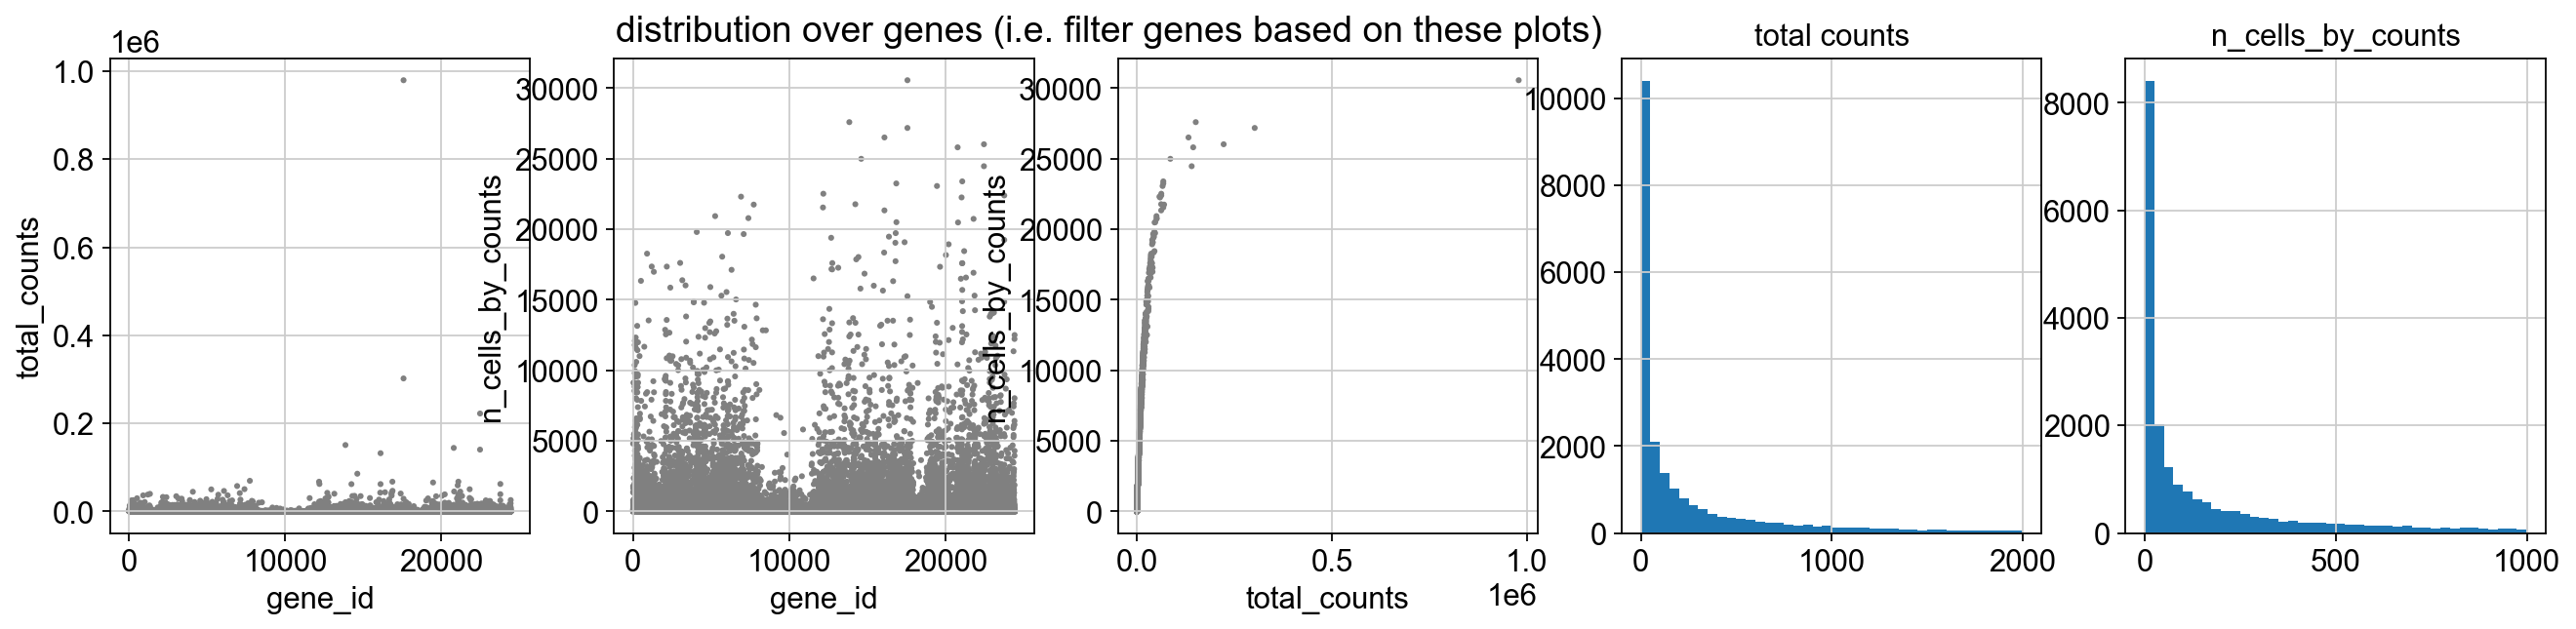

In [5]:
print("cell by gene ->", adata.X.shape)
print("-----------------------------")
print(adata.var['total_counts'].describe())  # the 25% percentile is a good place to filter
print("-----------------------------")
print(adata.var['n_cells_by_counts'].describe())  # the 25% percentile is a good place to filter
print("-----------------------------")
print(adata.var['pct_dropout_by_counts'].describe())

fig, axes = plt.subplots(ncols=5, figsize=(20,4))
fig.suptitle("distribution over genes (i.e. filter genes based on these plots)")
sc.pl.scatter(adata, x='gene_id', y='total_counts', ax=axes[0], size=30, show=False)
sc.pl.scatter(adata, x='gene_id', y='n_cells_by_counts', ax=axes[1], size=30, show=False)
_ = sc.pl.scatter(adata, x='total_counts', y='n_cells_by_counts', ax=axes[2], size=30, show=False)
_ = axes[3].hist(adata.var["total_counts"][adata.var["total_counts"] < 2000], bins=40)
_ = axes[3].set_title("total counts")
_ = axes[4].hist(adata.var["n_cells_by_counts"][adata.var["n_cells_by_counts"] < 1000], bins=40)
_ = axes[4].set_title("n_cells_by_counts")

### Distribution over cells

cell by gene -> (31659, 24450)
-----------------------------
count    31659.000000
mean       771.723112
std        563.300541
min         20.000000
25%        359.000000
50%        668.000000
75%       1067.000000
max       5973.000000
Name: total_counts, dtype: float64
-----------------------------
count    31659.000000
mean       567.065353
std        347.285842
min         14.000000
25%        306.000000
50%        534.000000
75%        786.000000
max       2980.000000
Name: n_genes_by_counts, dtype: float64


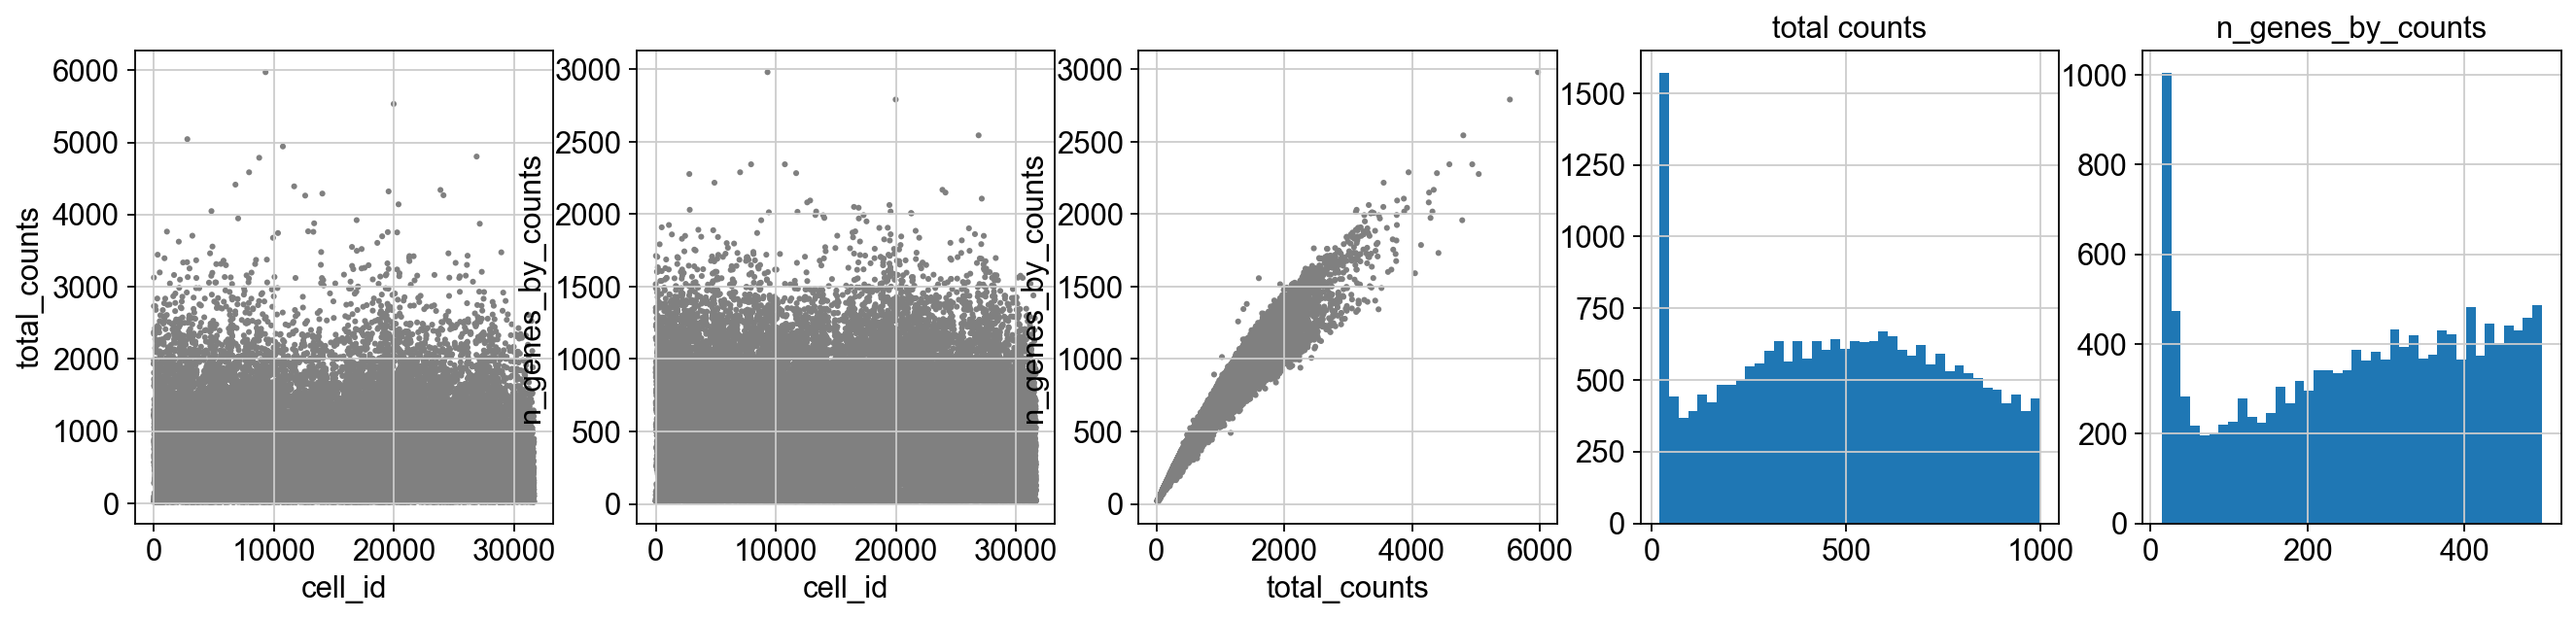

In [6]:
print("cell by gene ->", adata.X.shape)
print("-----------------------------")
print(adata.obs['total_counts'].describe())  # the 25% percentile is a good place to filter
print("-----------------------------")
print(adata.obs['n_genes_by_counts'].describe())  # the 25% percentile is a good place to filter

fig, axes = plt.subplots(ncols=5, figsize=(20,4))
sc.pl.scatter(adata, x='cell_id', y='total_counts', size=30, show=False, ax=axes[0])
sc.pl.scatter(adata, x='cell_id', y='n_genes_by_counts', size=30, show=False, ax=axes[1])
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', size=30, show=False, ax=axes[2])
_ = axes[3].hist(adata.obs["total_counts"][adata.obs["total_counts"] < 1000], bins=40)
_ = axes[3].set_title("total counts")
_ = axes[4].hist(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 500], bins=40)
_ = axes[4].set_title("n_genes_by_counts")

### Gene that are not present in cells

count    24450.000000
mean        97.680714
std          6.055108
min          3.442939
25%         98.336176
50%         99.715721
75%         99.971572
max        100.000000
Name: pct_dropout_by_counts, dtype: float64


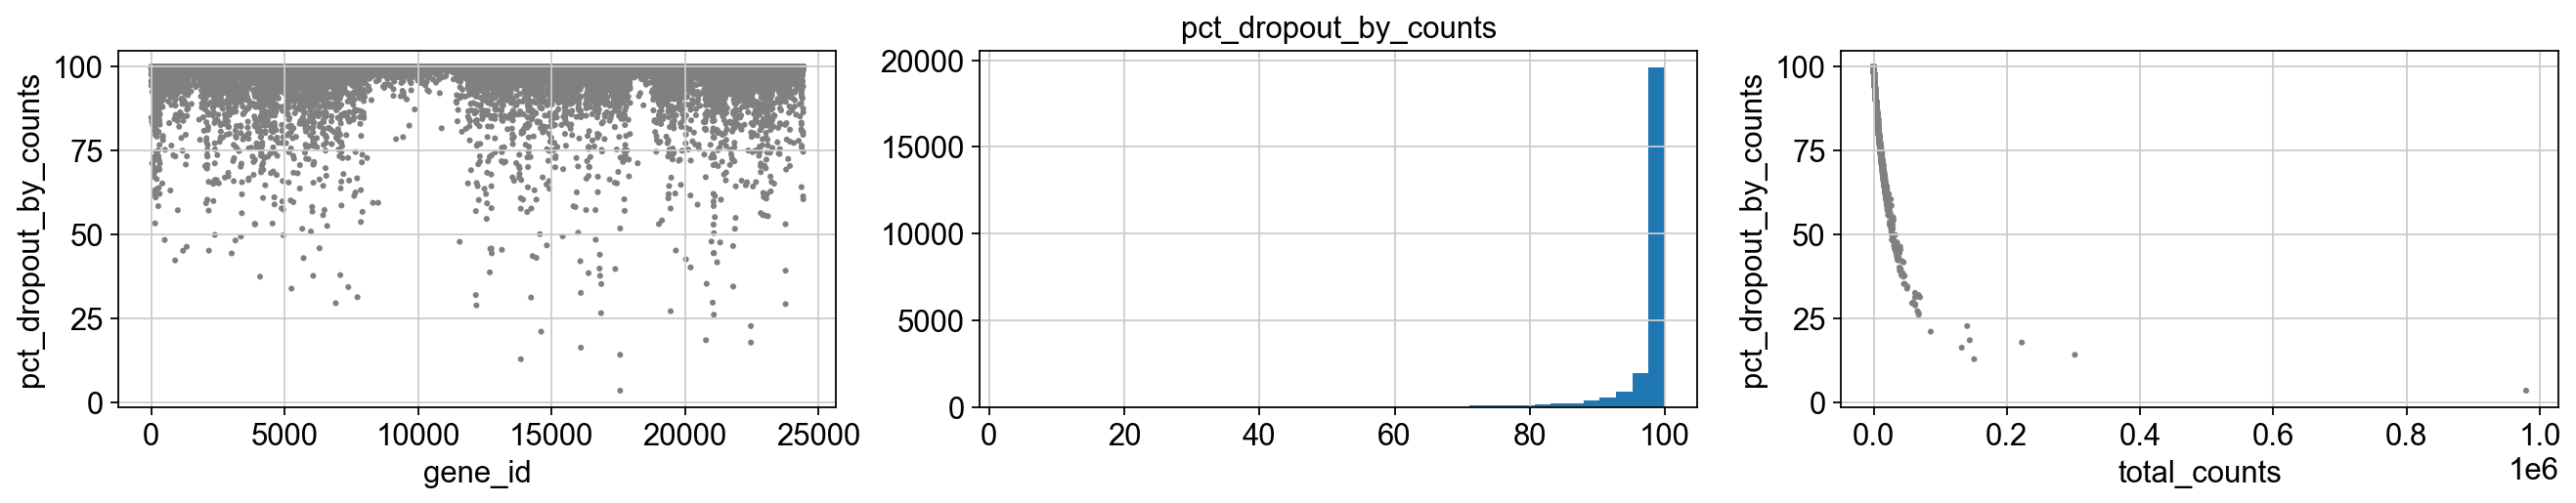

In [7]:
# there are almost no genes that are present in all the cells
print(adata.var['pct_dropout_by_counts'].describe())

fig, axes = plt.subplots(ncols=3, figsize=(20,3))
_ = sc.pl.scatter(adata, x='gene_id', y='pct_dropout_by_counts', ax=axes[0], size=30, show=False)
_ = axes[1].hist(adata.var["pct_dropout_by_counts"], bins=40)
_ = axes[1].set_title("pct_dropout_by_counts")
_ = sc.pl.scatter(adata, x='total_counts', y='pct_dropout_by_counts', ax=axes[2], size=30, show=False)

### Mitocondria check

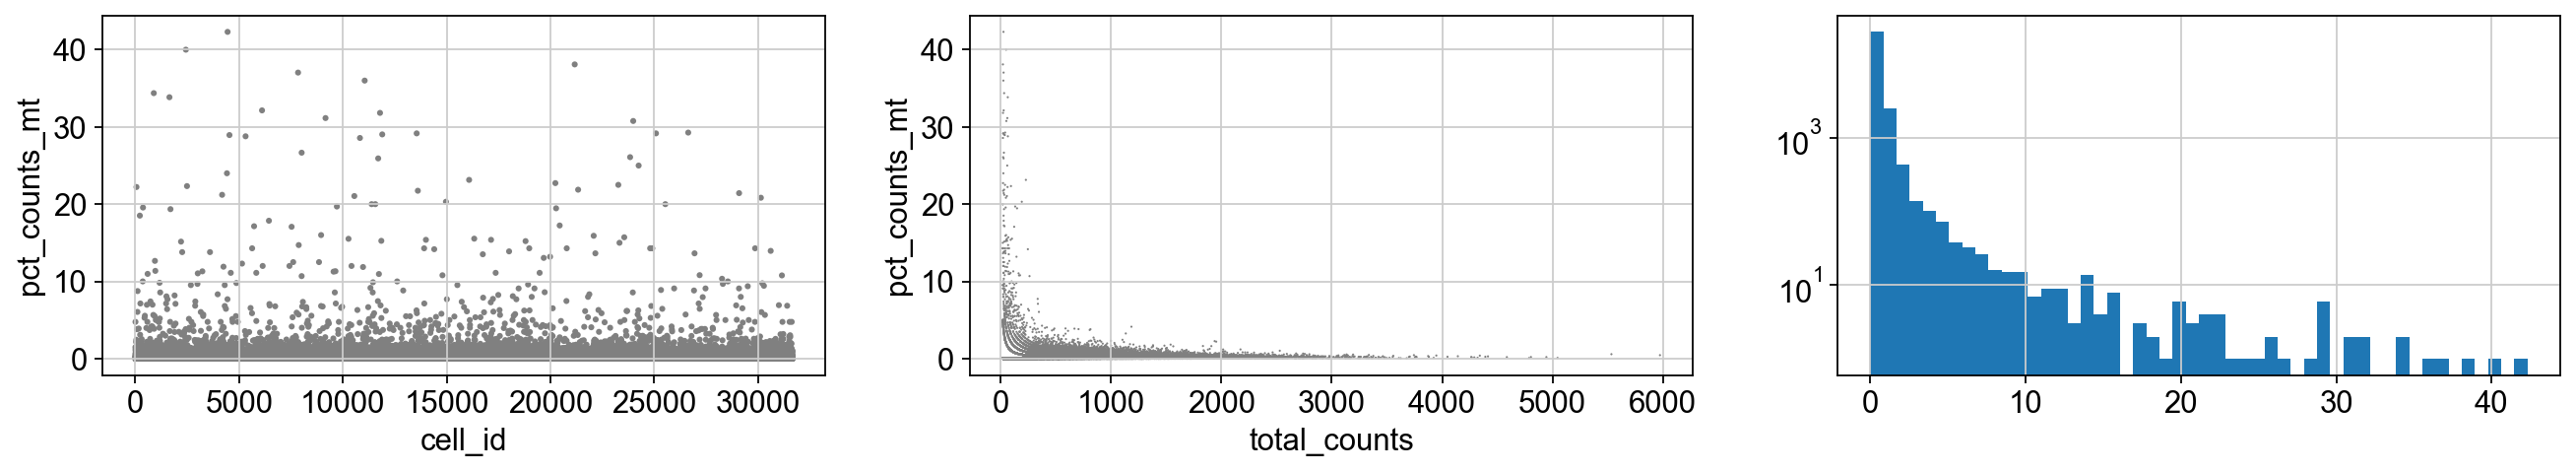

In [8]:
fig, axes = plt.subplots(ncols=3, figsize=(20,3))

_ = sc.pl.scatter(adata, x='cell_id', y='pct_counts_mt', ax=axes[0], size=30, show=False)
_ = sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax=axes[1], show=False)
_ = axes[2].hist(adata.obs['pct_counts_mt'], bins=50, density=False, log=True)

### Filtering. 
1. Filter out Bad cells:
   1. too few total mRNAs (bad capture)
   2. too many total mRNAs (doublet?)
   3. too few mRNAs types (low entropy cell)
   4. too much mitocondria (busted cell)  
2. Filter bad genes:
   1. expressed in too few cells (too rare to do anything with it)
   2. keep only highly variables genes


In [9]:
filter_cell = (adata.obs.pct_counts_mt < 5) * \
(adata.obs.n_genes_by_counts > 50) * \
(adata.obs.total_counts > 100) * \
(adata.obs.total_counts < 3000) 
adata = adata[filter_cell, :]

In [10]:
filter_genes = (adata.var.n_cells_by_counts > 10) # * (adata.var.n_cells_by_counts < 25000)
adata = adata[:, filter_genes]

In [11]:
adata

View of AnnData object with n_obs × n_vars = 28983 × 18102
    obs: 'x', 'y', 'cell_type', 'regress_moran_closest', 'cell_id', 'cell_type_codes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'feature_barlow_closest', 'feature_cell_number_closest', 'feature_composition_closest'

### Compute Neighbourhood composition vector and add to adata

In [12]:
x = adata.obs['x'].to_numpy()
y = adata.obs['y'].to_numpy()
cell_types_codes = adata.obs['cell_type_codes'].values
cell_types_one_hot = torch.nn.functional.one_hot(torch.tensor(cell_types_codes))

In [13]:
from sklearn.neighbors import KDTree

metric_features = numpy.stack((x,y), axis=-1)
kdtree = KDTree(metric_features)
print(metric_features.shape)

for k in (5, 25, 50, 100, 200, 300, 400, 500, 750, 1000, 2000):
    dist, ind = kdtree.query(metric_features, k=k)
  
    print(k, dist.shape, ind.shape)

    # compute the neighborhood composition vector
    ncv_tmp = cell_types_one_hot[ind].sum(dim=-2)
    ncv = ncv_tmp.float() / ncv_tmp.sum(dim=-1, keepdim=True)

    adata.obsm['ncv_'+str(k)] = ncv.cpu().numpy()

(28983, 2)
5 (28983, 5) (28983, 5)
25 (28983, 25) (28983, 25)
50 (28983, 50) (28983, 50)
100 (28983, 100) (28983, 100)
200 (28983, 200) (28983, 200)
300 (28983, 300) (28983, 300)
400 (28983, 400) (28983, 400)
500 (28983, 500) (28983, 500)
750 (28983, 750) (28983, 750)
1000 (28983, 1000) (28983, 1000)
2000 (28983, 2000) (28983, 2000)


### Check the count distribution

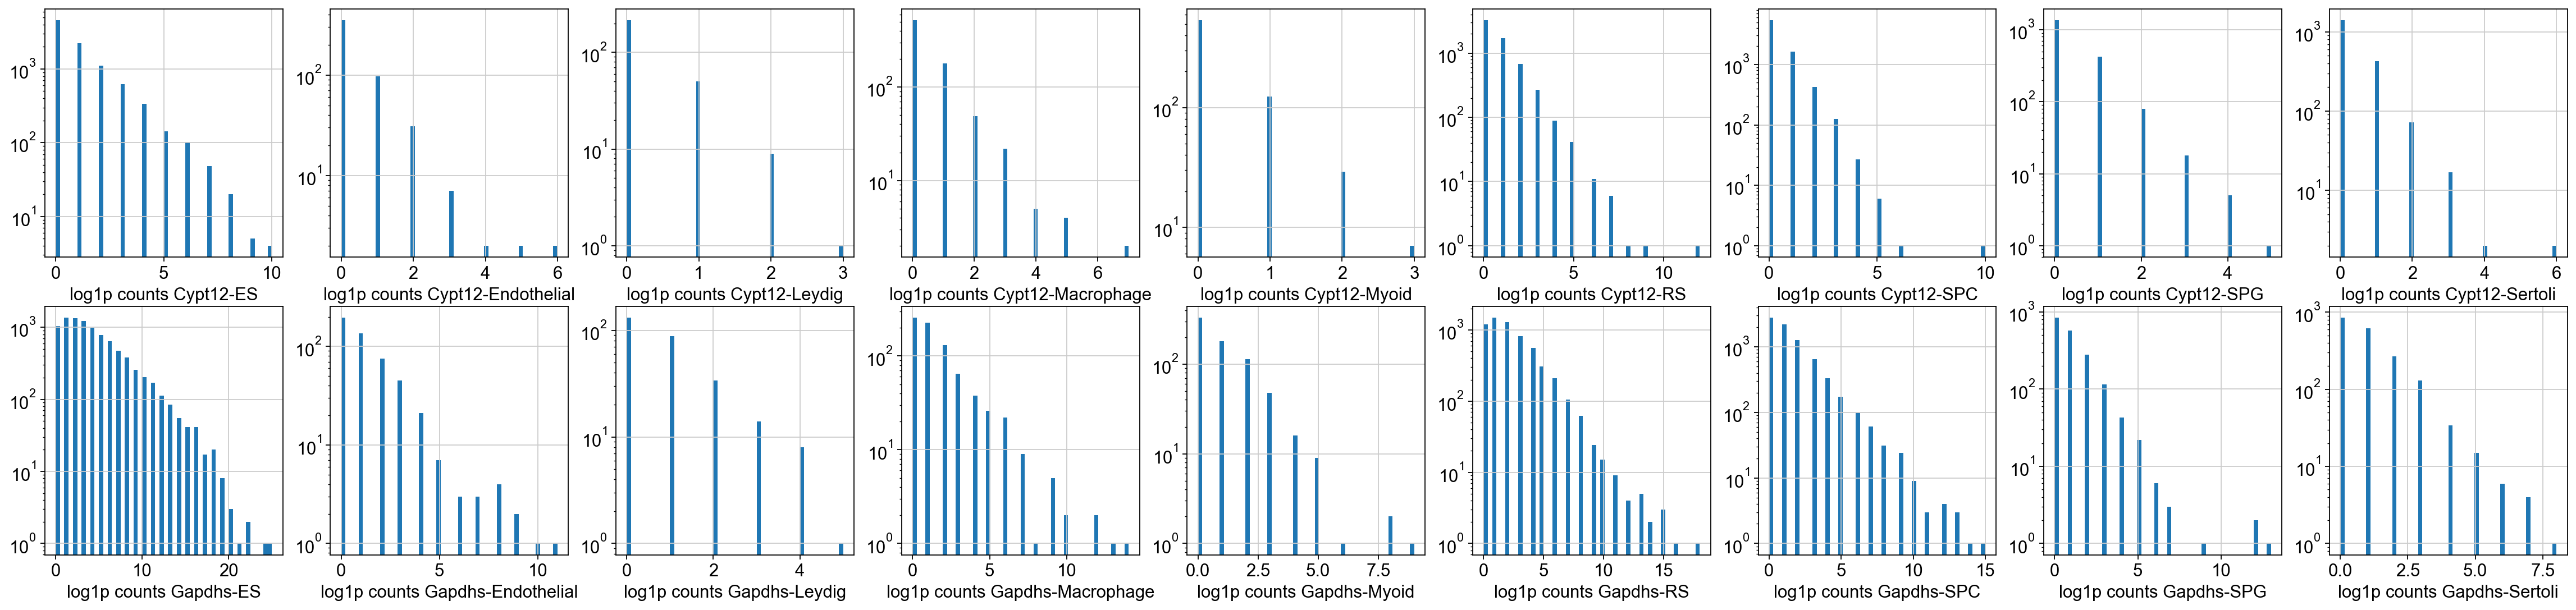

In [14]:
def plot_histo_gene_by_cell_type(input_adata, cell_types, genes):
    ncols = len(cell_types)
    nrows = len(genes)

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))
    for r, g_type in enumerate(genes):
        adata_by_gene = input_adata[:, input_adata.var.index == g_type]
        for c, c_type in enumerate(cell_types):
            adata_tmp = adata_by_gene[adata_by_gene.obs.cell_type == c_type] 
            _ = axes[r,c].hist(adata_tmp.X.toarray(), bins=50, density=False, log=True)
            _ = axes[r,c].set_xlabel("log1p counts {0}-{1}".format(g_type,c_type))
    plt.close()
    return fig

fig = plot_histo_gene_by_cell_type(
    adata, 
    cell_types=numpy.unique(adata.obs['cell_type']), 
    genes=['Cypt12', 'Gapdhs'])
fig

### Save before subsetting the genes

In [ ]:
# adata.write_h5ad(filename="adata_before_subset.h5ad")

### Reload and subset the genes

In [3]:
import torch
import pandas as pd
import scanpy as sc
import anndata
import numpy 
import matplotlib.pyplot as plt
import seaborn

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

adata = anndata.read_h5ad(filename="adata_before_subset.h5ad")
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=200)  # use count data
adata = adata[:, adata.var.highly_variable]

scanpy==1.8.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.2 scipy==1.6.2 pandas==1.3.4 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.0 leidenalg==0.8.3 pynndescent==0.5.2
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [78]:
def generate_fake_data(X_nl, g, k=1, alpha_scale=1E-2, alpha0_loc=-6.0, alpha0_scale=0.5, noise_scale=0.5):
    n, l = X_nl.shape[:2]
    cell_ids_n = torch.randint(low=0, high=k, size=[n])
    total_umi_n1 = torch.randint(low=250, high=3000, size=[n,1])
    alpha_klg = alpha_scale * torch.randn((k,l,g))
    alpha0_kg = alpha0_loc + alpha0_scale * torch.randn((k,g))
    eps_g = torch.randn(g) * noise_scale  # std per gene
    eps_ng = torch.randn(n,g) * eps_g
    
    log_mu_ng = alpha0_kg[cell_ids_n] + (X_nl[...,None] * alpha_klg[cell_ids_n]).sum(dim=-2) 
    mu_ng = (log_mu_ng + eps_ng).exp()
    rate_ng = total_umi_n1 * mu_ng
    counts_ng = torch.poisson(rate_ng).long()
    
    results = {
        "cell_type_ids_n": cell_ids_n,
        "counts_ng": counts_ng,
        "alpha0_kg": alpha0_kg,
        "alpha_klg": alpha_klg,
        "X_nl": X_nl
    }
    return results


X_nl = torch.randn((2000,10))
fake_data = generate_fake_data(X_nl, g=200, k=9)

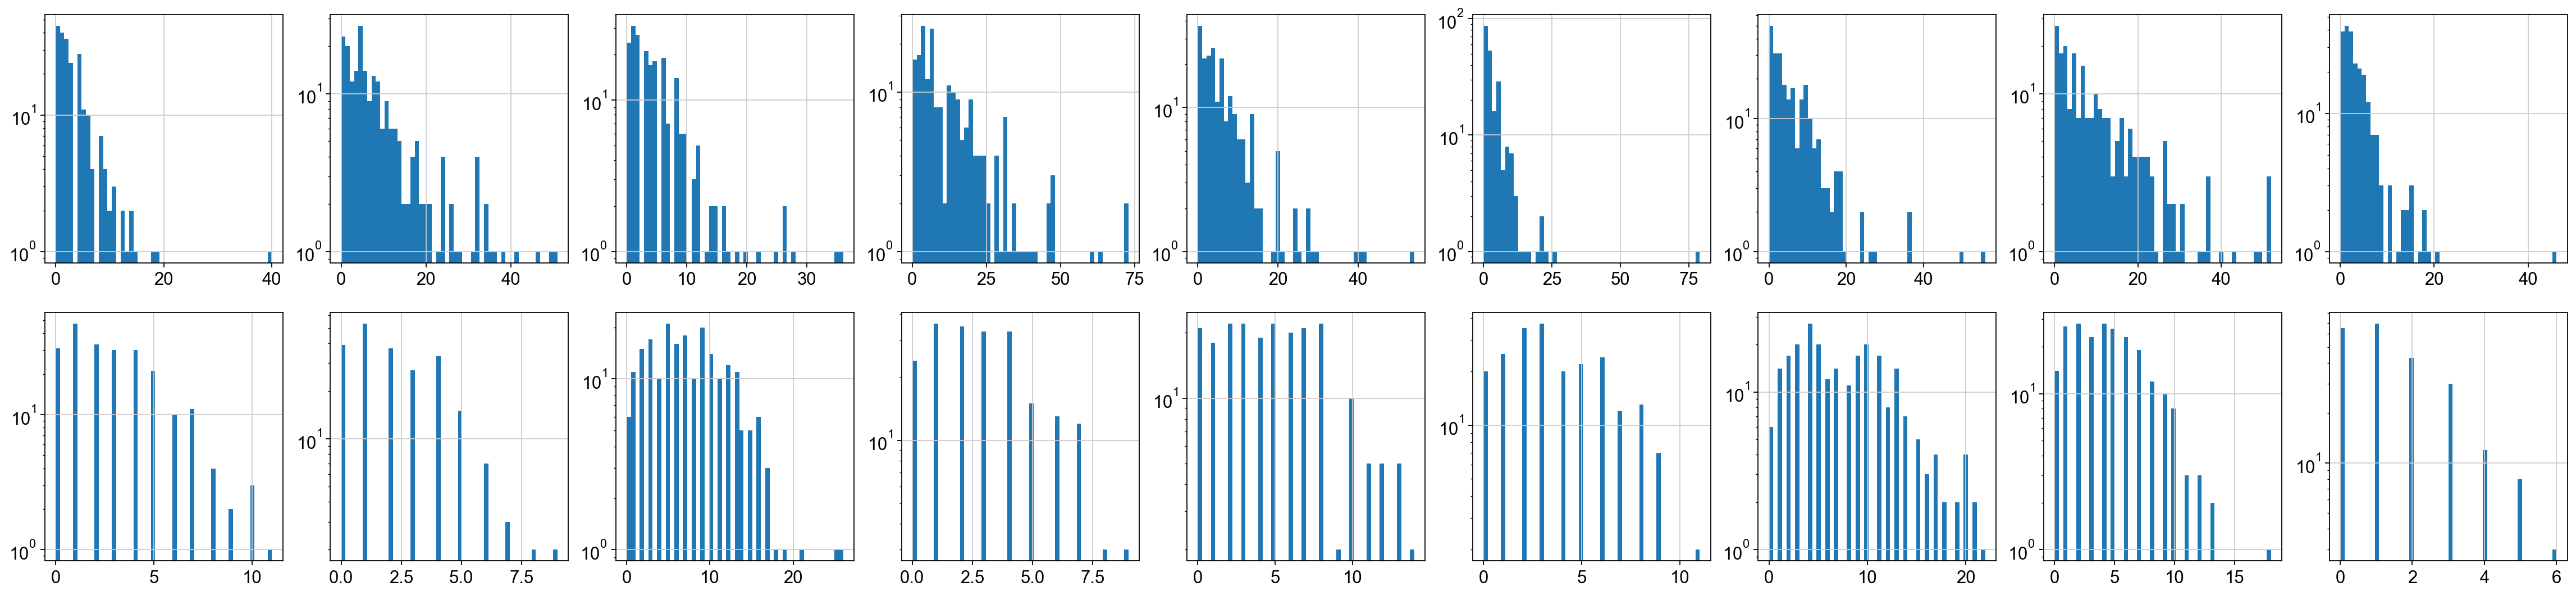

In [79]:
def plot_few_gene_hist(counts_ng, cell_types_n, ncols=4):
    assert counts_ng.shape[0] == cell_types_n.shape[0]
    ctypes = torch.unique(cell_types_n)
    genes = counts_ng.shape[-1]
    
    nrows = genes
    ncols = len(ctypes)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

    for r in range(genes):
        tmp = counts_ng[:,r]
        for c, c_type in enumerate(ctypes):
            tmp2 = tmp[cell_types_n == c_type]
            _ = axes[r,c].hist(tmp2, bins=50, density=False, log=True)
    plt.close()
    return fig

counts_ng = fake_data["counts_ng"]
cell_types_n = fake_data["cell_type_ids_n"]
fig = plot_few_gene_hist(counts_ng[:,:2], cell_types_n, ncols=3)
fig

In [80]:
fake_dataset = {
    "cell_type_codes" : torch.zeros_like(fake_data["X_nl"][:,0]),
    "counts": fake_data["counts_ng"], 
    "covariates" : fake_data["X_nl"],
}                               
                                     
real_dataset = {
    "cell_type_codes" : torch.tensor(adata.obs["cell_type_codes"]),
    "counts": torch.tensor(adata.X.toarray()), 
    "covariates" : torch.tensor(adata.obsm["ncv_25"])
}

In [91]:
import time
a = time.time()
print("Traning time was {0:.3f} seconds".format(a))

Traning time was 1644595511.011 seconds


### Pyro model to fit the counts with a poisson_log_normal model

In [86]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta
from torch.distributions import constraints


def model_poisson_log_normal(dataset):
    check_shapes = True
    
    counts_ng = dataset['counts'].long()
    covariates_nl = dataset['covariates'].float()  
    cell_type_ids_n = dataset['cell_type_codes'].long()  # ids: 0,1,...,K-1
    k = cell_type_ids_n.max().item()+1
    
    if torch.cuda.is_available(): 
        counts_ng = counts_ng.cuda()
        covariates_nl = covariates_nl.cuda()
        cell_type_ids_n = cell_type_ids_n.cuda()
    device = counts_ng.device
    
    n, g = counts_ng.shape[:2]
    n, l = covariates_nl.shape[:2]
    n = cell_type_ids_n.shape[0]  
    assert isinstance(k, int) and k>0
    assert isinstance(l, int) and l>0
    assert isinstance(n, int) and n>0
    assert isinstance(g, int) and g>0
    
    if check_shapes:
        # print("k,n,g,l ->",k,n,g,l)
        assert counts_ng.shape[0] == covariates_nl.shape[0] == cell_type_ids_n.shape[0]
    
    eps_std_init = 0.01
    alpha0_init = -6.0
    alpha_init = 0.01
    
    eps_std_g = pyro.param("eps_std", 
                         eps_std_init * torch.randn(g, dtype=torch.float, device=device), 
                         constraint=constraints.interval(1E-4, 1E-1)) # shape g
    alpha0_kg = pyro.param("alpha0", 
                           alpha0_init * torch.ones((k,g), dtype=torch.float, device=device)) # shape k,g
    alpha_klg = pyro.param("alpha", 
                           alpha_init * torch.ones((k,l,g), dtype=torch.float, device=device)) # shape k,l,g
    
    alpha0_ng = alpha0_kg[cell_type_ids_n]
    alpha_nlg = alpha_klg[cell_type_ids_n]
    log_mu_ng = alpha0_ng + torch.sum(covariates_nl.unsqueeze(dim=-1) * alpha_nlg, dim=-2)
    
    with pyro.plate("cells", n, dim=-2):
        eps_ng = pyro.sample("eps", dist.Normal(loc=0, scale=eps_std_g))
        total_umi_n1 = counts_ng.sum(dim=-1, keepdim=True) 
    
        if check_shapes:
            assert eps_ng.shape == torch.Size([n, g]), "Got {0}".format(eps_ng.shape.shape)
            assert total_umi_n1.shape == torch.Size([n, 1]), "Got {0}".format(total_umi_n1.shape)
            assert alpha0_ng.shape == torch.Size([n, g]), "Got {0}".format(alpha0_ng.shape)
            assert alpha_nlg.shape == torch.Size([n, l, g]), "Got {0}".format(alpha_nlg.shape)
            assert covariates_nl.shape == torch.Size([n, l]), "Got {0}".format(covariates_nl.shape)
            assert log_mu_ng.shape == torch.Size([n, g]), "Got {0}".format(log_mu_ng.shape)
     
        with pyro.plate("genes", g, dim=-1):
            mu_ng = (log_mu_ng + eps_ng).exp()
            rate_ng = mu_ng * total_umi_n1 
            
            if check_shapes:
                log_mu_ng.shape == mu_ng.shape == counts_ng.shape == torch.Size([n,g])
                           
            pyro.sample("counts", dist.Poisson(rate_ng), obs=counts_ng)
    
guide_poisson_log_normal = AutoDelta(model_poisson_log_normal)



def train(model, guide, dataset, lr=0.005, n_steps=2500, print_frequency=50, clear_param_store=True):
    if clear_param_store:
        pyro.clear_param_store()
    
    adam = pyro.optim.Adam({"lr": lr})
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    for i in range(n_steps):
        loss = svi.step(dataset)
        if i % print_frequency == 0:
            print('[iter {}]  loss: {:.4f}'.format(i, loss))

In [87]:
# train(model_mle, guide_mle, dataset)
train(model_poisson_log_normal, guide_poisson_log_normal, fake_dataset, 
      n_steps=500, print_frequency=50,
     clear_param_store=True)

#for name, value in pyro.get_param_store().items():
#    print(name, pyro.param(name))

[iter 0]  loss: 265158.2500
[iter 50]  loss: -79268.0000
[iter 100]  loss: -299155.2500
[iter 150]  loss: -454705.6250
[iter 200]  loss: -571769.5000
[iter 250]  loss: -676044.3750
[iter 300]  loss: -771447.1250
[iter 350]  loss: -861664.3750
[iter 400]  loss: -947050.8750
[iter 450]  loss: -1026359.2500


In [88]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

eps_std tensor([0.0012, 0.0011, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0009,
        0.0011, 0.0010, 0.0010, 0.0011, 0.0011, 0.0009, 0.0009, 0.0010, 0.0010,
        0.0011, 0.0011, 0.0009, 0.0009, 0.0010, 0.0010, 0.0010, 0.0010, 0.0012,
        0.0011, 0.0009, 0.0011, 0.0010, 0.0010, 0.0010, 0.0009, 0.0010, 0.0010,
        0.0010, 0.0011, 0.0009, 0.0009, 0.0010, 0.0010, 0.0009, 0.0009, 0.0009,
        0.0012, 0.0009, 0.0010, 0.0009, 0.0010, 0.0011, 0.0010, 0.0011, 0.0011,
        0.0009, 0.0011, 0.0010, 0.0010, 0.0011, 0.0011, 0.0010, 0.0009, 0.0010,
        0.0010, 0.0011, 0.0009, 0.0010, 0.0010, 0.0009, 0.0010, 0.0012, 0.0012,
        0.0010, 0.0008, 0.0010, 0.0010, 0.0009, 0.0011, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0009, 0.0010, 0.0009, 0.0011, 0.0011, 0.0010, 0.0008, 0.0010,
        0.0010, 0.0010, 0.0011, 0.0010, 0.0010, 0.0011, 0.0010, 0.0009, 0.0010,
        0.0011, 0.0009, 0.0010, 0.0009, 0.0012, 0.0009, 0.0010, 0.0010, 0.0009,
        0.0011, 0.0011, 0.0011, 

In [67]:
fake_data["alpha0_kg"]

tensor([[-6.6188, -5.9215, -5.8467,  ..., -7.4370, -5.9290, -6.0488],
        [-6.5339, -5.7982, -6.2628,  ..., -6.6406, -5.7995, -6.6982],
        [-5.6743, -6.1480, -5.6415,  ..., -6.2613, -6.1821, -6.7212],
        ...,
        [-5.3520, -6.3406, -6.0991,  ..., -5.2804, -5.7436, -5.8209],
        [-6.4156, -6.7769, -5.5108,  ..., -5.9769, -6.0935, -6.4646],
        [-5.5560, -5.4666, -6.0197,  ..., -5.8169, -5.8972, -6.4555]])

In [25]:
fake_data["alpha0"].shape
#pyro.param("alpha0").shape

KeyError: 'alpha0'

# FROM HERE

### Normalize, log_transf, highly_variable genes

In [ ]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat")

### PCA, UMAP, LEIDEN

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

### Plot the covariate on the gene expression embeddings

In [ ]:
sc.pl.pca(adata, color=["total_counts", "n_genes_by_counts", "clusters", "cell_type", "regress_moran_closest"], wspace=0.4, ncols=3)

In [ ]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters", "cell_type", "regress_moran_closest"], wspace=0.4, ncols=3)

In [ ]:
adata

In [ ]:
cell_type = adata.obs["cell_type"]
unique_cell_type = numpy.unique(cell_type)

fig, axes = plt.subplots(ncols=len(unique_cell_type), figsize=(4*len(unique_cell_type), 4))
for n, c_type in enumerate(unique_cell_type):
    sc.pl.umap(adata, ax=axes[n], show=False)
    sc.pl.umap(adata[adata.obs.cell_type == c_type, :], ax=axes[n], color="clusters", size=10, show=False)
    axes[n].set_title(c_type)

In [ ]:
clusters = adata.obs["clusters"].values
unique_clusters = numpy.unique(clusters)

fig, axes = plt.subplots(ncols=len(unique_clusters), figsize=(4*len(unique_clusters), 4))
for n, c_type in enumerate(unique_clusters):
    sc.pl.umap(adata, ax=axes[n], show=False)
    sc.pl.umap(adata[adata.obs.clusters == c_type, :], ax=axes[n], color="cell_type", size=10, show=False)
    axes[n].set_title("cluster -->"+str(c_type))

### plot some annotation in space

In [ ]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(4*4,4*2))
_ = seaborn.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['cell_type'], size=1, sizes=(3,3), ax=axes[0,0])
_ = seaborn.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['clusters'], size=1, sizes=(3,3), ax=axes[0,1])
_ = seaborn.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['pct_counts_mt'], size=1, sizes=(3,3), ax=axes[0,2])
_ = seaborn.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['total_counts'], size=1, sizes=(3,3), ax=axes[0,3])
_ = seaborn.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obsm['ncv_25'][:,0], size=1, sizes=(3,3), ax=axes[1,0])
_ = seaborn.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obsm['ncv_50'][:,0], size=1, sizes=(3,3), ax=axes[1,1])
_ = seaborn.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obsm['ncv_100'][:,0], size=1, sizes=(3,3), ax=axes[1,2])
_ = seaborn.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obsm['ncv_500'][:,0], size=1, sizes=(3,3), ax=axes[1,3])

In [ ]:
import sklearn
ari = sklearn.metrics.adjusted_rand_score(adata.obs["cell_type_codes"], adata.obs["clusters"])
ami = sklearn.metrics.adjusted_mutual_info_score(adata.obs["cell_type_codes"], adata.obs["clusters"])                                       
print(ari, ami)

### Filter to only the highly variable genes

In [ ]:
# adata = adata[:, adata.var.highly_variable]  # keep only the highly variable genes

### Check that the distribution of counts looks gaussian

In [ ]:
def try_different_normalization(adata_before_normalization):
    figs = []
    for exclude_highly_expressed in [False, True]:
        for target_sum in [1.0, None, 1.0E6]:
            adata_tmp = adata_before_normalization.copy()
            sc.pp.normalize_total(adata_tmp, inplace=True, target_sum=target_sum, exclude_highly_expressed= exclude_highly_expressed)
            sc.pp.log1p(adata_tmp)
            fig = plot_histo_gene_by_cell_type(
                adata_tmp, 
                cell_types=numpy.unique(adata_tmp.obs['cell_type']), 
                genes=['Cypt12', 'Gapdhs'])
            figs.append(fig)
    return figs

figs = try_different_normalization(adata_before_normalization)
    




In [ ]:
figs[0]

In [ ]:
figs[1]

In [ ]:
figs[2]

In [ ]:
figs[3]

In [ ]:
figs[4]

In [ ]:
figs[5]

# Predict just Gapdhs

In [ ]:
adataES = adata[adata.obs.cell_type == 'ES', :]
adataES_Gapdhs = adataES[:, adataES.var.index == 'Gapdhs'] 

_ = plt.hist(adataES_Gapdhs.X.toarray(), bins=50, density=False, log=True)

In [ ]:
adataES_Gapdhs

In [ ]:
is_expressed = (adataES_Gapdhs.X > 0).toarray()[:,0]
log1p_counts = adataES_Gapdhs.X.toarray()[:,0]
ncv_25 = adataES_Gapdhs.obsm['ncv_25']
print(is_expressed.shape)
print(log1p_counts.shape)
print(ncv_25.shape)

### Poisson-Log-Normal fit 

1. DO MORE GENES, DO CROSS FOLD, DO RIDGE REGRESSION
2. MAKE A PLOT OF R2 and ERROR vs Length_scale
3. USE BArlow features
4. select a better gene

In [ ]:
from torch.distributions import Poisson, Normal

In [ ]:
def sample_poisson_log_normal(N_samples, Total_counts=500, std_noise=1.2, log_lambda_determinatistic=-6.0):
    noise = torch.randn(N_samples) * std_noise
    log_lambda = log_lambda_determinatistic + noise
    mylambda = log_lambda.exp()
    return torch.poisson(mylambda * Total_counts)

counts = sample_poisson_log_normal(N_samples=10000)

In [ ]:
c = torch.bincount(x.long())
plt.plot(torch.arange(c.shape[0])[:20],c[:20], '-x')

In [71]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta

def model_poisson_log_normal(dataset):
    
    counts = dataset['counts']  
    covariates = dataset['covariates'].float()  
    cell_type_ids = dataset['cell_type_codes'].long()  # ids: 0,1,...,K-1
    k = dataset['max_cell_types']
    
    n, g = counts.shape
    n, l = covariates.shape
    n = cell_type.shape    
    assert cell_type.max() == k-1
    assert counts.shape[0] == covariates.shape[0] == cell_type_ids.shape[0]
    
    eps_std_init = 0.01
    alpha0_init = 0.1
    
    eps_std = pyro.param("eps_std", 
                         eps_std_init*torch.ones(g), 
                         constraints=constraints.interval(1E-4, 1E-1)) # shape g
    alpha0 = pyro.param("alpha0", 
                        alpha0_init*torch.ones(k)) # shape k,g
    alpha = pyro.param("alpha", 
                        alpha_init*torch.ones(k,l)) # shape k,l,g
    
    log_mu_deterministic = alpha0[cell_type_ids] + torch.einsum("nl,lg -> ng", covariate, alpha[cell_type_ids])
    total_umi = counts.sum(dim=-1, keep_dim=True)  # shape: n,g
    
    with pyro.plate("cells", n, -2):
        with pyro.plate("genes", g, -1):
            eps = pyro.sample("eps", dist.Normal(loc=0, scale=eps_std))  # shape: n, g
            log_mu = log_mu_deterministic + eps
            mu = log_mu.exp() * total_umi 
            pyro.sample("counts", dist.Poisson(mu).to_event(1), obs=counts)
    
guide_poisson_log_normal = AutoDelta(model_poisson_log_normal)

def train(model, guide, dataset, lr=0.05, n_steps=2500, print_frequency=50):
    pyro.clear_param_store()
    adam = pyro.optim.Adam({"lr": lr})
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    for i in range(n_steps):
        loss = svi.step(dataset)
        if i % print_frequency == 0:
            print('[iter {}]  loss: {:.4f}'.format(i, loss))

In [ ]:
adata_before_normalization

In [ ]:
torch.tensor(adata_before_normalization.X.toarray())

In [ ]:
dataset = {
    "max_cell_types" : 1,
    "cell_type_codes" : torch.tensor(adata_before_normalization.obs["cell_type_codes"]),
    "counts": torch.tensor(adata_before_normalization.X.toarray()), 
    "covariates" : torch.tensor(cell_type_onehot)
}

# train(model_mle, guide_mle, dataset)
train(model_map, guide_map, dataset)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

# FROM HERE. 

1. DO MORE GENES, DO CROSS FOLD, DO RIDGE REGRESSION
2. MAKE A PLOT OF R2 and ERROR vs Length_scale
3. USE BArlow features
4. select a better gene

### Use NCVs

In [ ]:
ncv_keys = []
for a in adataES_Gapdhs.obsm.keys():
    if a.startswith("ncv"):
        ncv_keys.append(a)
print(ncv_keys)

for ncv_key in ncv_keys:
    X = adataES_Gapdhs.obsm[ncv_key][is_expressed]
    y = log1p_counts[is_expressed]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("------")
    print(ncv_key)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', numpy.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('coefficient of determination test:', model.score(X_test, y_test))
    print('coefficient of determination train:', model.score(X_train, y_train))

In [ ]:
# y_pred = model.predict(X_test)
# pred = pd.DataFrame({'True_value': y_test, 
#                      'Predicted': y_pred},
#                    index=numpy.arange(y_pred.shape[0]))
# pred

In [ ]:
# pred1 = pred.head(25)
# pred1.plot(kind='bar',figsize=(16,10))
# plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
# plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# plt.show()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', numpy.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('coefficient of determination:', model.score(X_test, y_test))

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(4*2, 4))
_ = axes[0].scatter(y_test, y_pred, c='b')
_ = axes[0].set_xlabel("y_test")
_ = axes[0].set_ylabel("y_pred")

_ = axes[1].scatter( y_pred, (y_pred - y_test), c='b')
_ = axes[1].set_xlabel('Fitted values')
_ = axes[1].set_ylabel('residuals')
_ = axes[1].set_title('Residuals vs Fitted')
_ = axes[1].axhline(y=0, color='red', linestyle='dashed')

### LinearModel for non-zero

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [ ]:
X = adataES_Gapdhs.obsm["feature_barlow_closest"][is_expressed]
y = log1p_counts[is_expressed]
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', numpy.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('coefficient of determination:', model.score(X_test, y_test))

### Logistic Regression

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

model = LinearRegression()
model.fit(X_train, y_train)
adataES_Gapdhs

In [ ]:
adataES_Gapdhs

adata

In [ ]:
# total_gene_per_cell = numpy.asarray(adata.X.sum(axis=-1)).flatten()
total_gene_per_cell = adata.obs["total_counts"]

adata_Gapdhs = adata[:, adata.var.index == 'Gapdhs'] 

raw_counts = adata_Gapdhs.X.toarray()
raw_counts_pdf_unnormalized = numpy.bincount(raw_counts.flatten())
raw_counts_pdf_normalized = raw_counts_pdf_unnormalized / raw_counts_pdf_unnormalized.sum()

cell_types = adata_Gapdhs.obs['cell_type'].values
cell_type_unique = numpy.unique(cell_types)
cell_type2code = dict(zip(cell_type_unique, numpy.arange(len(cell_type_unique))))
cell_type_codes = torch.tensor([cell_type2code[c] for c in cell_types])
cell_type_onehot = torch.nn.functional.one_hot(cell_type_codes).numpy()

fake_covariates = torch.randn((raw_counts.shape[0],5))

In [ ]:
# Poisson 
mu = raw_counts.mean()
poisson = Poisson(rate=mu)

x = torch.arange(30)
log_y = poisson.log_prob(x)

fig, axes = plt.subplots(ncols=2, figsize=(12,4))

_ = axes[0].plot(x, raw_counts_pdf_normalized, 'o', color='blue')
_ = axes[0].plot(x, log_y.exp(), 'x-', color='red')

_ = axes[1].plot(x, raw_counts_pdf_normalized, 'o', color='blue')
_ = axes[1].plot(x, log_y.exp(), 'x-', color='red')
axes[1].set_yscale("log")

In [ ]:
total_gene_per_cell[:, 0].shape

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
_ = axes[0].hist(raw_counts[:,0], bins=30, density=False, log=True)
_ = axes[1].hist(raw_counts[:,0], bins=30, density=False, log=False)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
_ = axes[0].hist(total_gene_per_cell, bins=200, density=False, log=True)
_ = axes[1].hist(total_gene_per_cell, bins=200, density=False, log=False)

In [ ]:
log1p_counts = numpy.log1p(raw_counts[:, 0] * 500/ total_gene_per_cell)
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
_ = axes[0].hist(log1p_counts, bins=50, density=False, log=True)
_ = axes[1].hist(log1p_counts, bins=50, density=False, log=False)

### Martin NegativeBinomial

In [ ]:
psi0 = torch.zeros(raw_counts.shape[0])
print(raw_counts.shape, psi0.shape, cell_type_onehot.shape, fake_covariates.shape)

In [ ]:
Ypsi0X = numpy.concatenate([raw_counts, psi0[:, None], cell_type_onehot, fake_covariates], axis=-1)

columns = ['Response', 'Psi0'] 
columns += list(cell_type_unique)
columns += ['fake{}'.format(k) for k in range(5)]
dataframe = pd.DataFrame(Ypsi0X, columns=columns)
dataframe.head(5)

In [ ]:
selector = NegativeBinomialLikelihoodVariableSelector(dataframe,  # pass in the data
                                            'Response', # indicate the column of responses
                                            'Psi0',      # shift 
                                            S=1,        # specify the expected number of covariates to include a priori
                                           )

In [ ]:
selector.run(T=2000, T_burnin=1000, verbosity='bar', seed=2,  streaming=True)

In [ ]:
selector.summary

In [ ]:
selector.stats

In [ ]:
coeff = selector.summary['Coefficient'].values
beta = coeff[:-1]
beta0 = coeff[-1]
print(beta.shape, beta0.shape)


dataframe


# Pyro approach

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta

def r_p_to_mu_nu(r, p):
    mu = p * r /(1-p)
    nu = r
    return (mu, nu)

def mu_nu_2_r_p(mu, nu):
    r  = nu
    p = mu / (mu+nu)
    return (r, p)

def model_mle(dataset):
    counts = dataset['counts']
    covariates = dataset['covariates'].float()
    n_cells, n_genes = counts.shape
    n_cells, n_covs = covariates.shape
    assert counts.shape[0] == covariates.shape[0]
    
    tau0 = 0.0001 * torch.ones(n_genes)
    tau = 0.01 * torch.ones(n_genes, n_covs)
    beta0 = pyro.param("beta0", dist.Normal(loc=0.0, scale=1.0/tau0).sample())      
    beta = pyro.param("beta", dist.Normal(loc=0.0, scale=1.0/tau).sample())      
    log_nu = pyro.param("log_nu", torch.zeros(n_genes))      
    log_mean = beta0 + torch.einsum("cn,gn->cg", covariates.float(), beta) 
      
    with pyro.plate("cells", n_cells):
        r, p = mu_nu_2_r_p(mu=log_mean.exp(), nu=log_nu.exp())
        count_dist = dist.NegativeBinomial(total_count=r, probs=p)
        # count_dist = dist.Normal(loc=log_mean.exp(), scale=1)
        pyro.sample("counts", count_dist.to_event(1), obs=counts)
    
    
def model_map(dataset):
    counts = dataset['counts']
    covariates = dataset['covariates'].float()
    n_cells, n_genes = counts.shape
    n_cells, n_covs = covariates.shape
    assert counts.shape[0] == covariates.shape[0]
    
    tau0 = 0.0001 
    tau = 0.01 
    
    with pyro.plate("genes", n_genes):
        beta0 = pyro.sample("beta0", dist.Normal(loc=0, scale=1.0/tau0))   
        with pyro.plate("covs", n_covs):
            beta = pyro.sample("beta", dist.Normal(loc=0, scale=1.0/tau))     
            
    log_nu = pyro.param("log_nu", torch.zeros(n_genes))                    
    log_mean = beta0 + torch.einsum("cn,gn->cg", covariates.float(), beta) 
      
    with pyro.plate("cells", n_cells):
        r, p = mu_nu_2_r_p(mu=log_mean.exp(), nu=log_nu.exp())
        count_dist = dist.NegativeBinomial(total_count=r, probs=p)
        # count_dist = dist.Normal(loc=log_mean.exp(), scale=1)
        pyro.sample("counts", count_dist.to_event(1), obs=counts)
    
    
def guide_mle(dataset):
    pass


guide_map = AutoDelta(model_map)


dataset = {
    "counts": torch.tensor(raw_counts), 
    "covariates" : torch.tensor(cell_type_onehot)
}

In [ ]:
def train(model, guide, dataset, lr=0.05, n_steps=2500, print_frequency=50):
    pyro.clear_param_store()
    adam = pyro.optim.Adam({"lr": lr})
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    for i in range(n_steps):
        loss = svi.step(dataset)
        if i % print_frequency == 0:
            print('[iter {}]  loss: {:.4f}'.format(i, loss))
            
# train(model_mle, guide_mle, dataset)
train(model_map, guide_map, dataset)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

In [ ]:
train(model_mle, guide_mle, dataset)
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
    
selector.summary['Coefficient']    

### Martin NegativeBinomial

In [ ]:
psi0 = torch.zeros(raw_counts.shape[0])
print(raw_counts.shape, psi0.shape, cell_type_onehot.shape, fake_covariates.shape)

Ypsi0X = numpy.concatenate([raw_counts, psi0[:, None], cell_type_onehot, fake_covariates], axis=-1)

In [ ]:
columns = ['Response', 'Psi0'] 
columns += list(cell_type_unique)
columns += ['fake{}'.format(k) for k in range(5)]
dataframe = pd.DataFrame(Ypsi0X, columns=columns)
dataframe.head(5)

In [ ]:
selector = NegativeBinomialLikelihoodVariableSelector(dataframe,  # pass in the data
                                            'Response', # indicate the column of responses
                                            'Psi0',      # shift 
                                            S=1,        # specify the expected number of covariates to include a priori
                                           )

selector.run(T=2000, T_burnin=1000, verbosity='bar', seed=2,  streaming=True)

In [ ]:
selector.summary['Coefficient']

In [ ]:
selector.stats

# FROM HERE

In [ ]:
adata_GAPDHS = adata[:, adata.var.index == "Gapdhs"]

In [ ]:
import pandas as pd

cell_type = adata_GAPDHS.obs['cell_type']
log1p = adata_GAPDHS.X.toarray().flatten()
barlow = adata.obsm['feature_barlow_closest']
composition = adata.obsm['feature_composition_closest']
ncv25 = adata.obsm['ncv_25']

In [ ]:
print(cell_type.shape)
print(log1p.shape)
print(barlow.shape)
print(composition.shape)
print(ncv25.shape)

### use cell type only

In [ ]:
adata_GAPDHS.X.toarray().flatten()

In [ ]:
adata

In [ ]:
mydf

In [ ]:
adata_GAPDHS

# Analyze the embeddings

In [ ]:
from tissue_purifier.misc_utils.misc import SmartPca, SmartUmap


smart_pca = SmartPca(preprocess_strategy='z_score')
smart_umap = SmartUmap(n_neighbors=25, preprocess_strategy='raw',
                       n_components=2, min_dist=0.5, metric='euclidean')

barlow_features = adata.obsm['feature_barlow_closest']
print(barlow_features.shape)

embeddings_pca = smart_pca.fit_transform(barlow_features, n_components=0.95)
embeddings_umap = smart_umap.fit_transform(embeddings_pca)

In [ ]:
from tissue_purifier.plot_utils.plot_embeddings import plot_embeddings
from tissue_purifier.misc_utils.dict_util import inspect_dict


mydict = {
    "pca": embeddings_pca,
    "umap": embeddings_umap,
    "cell_type": adata.obs['cell_type'].to_numpy(),
    "moran": adata.obs['regress_moran_closest'].to_numpy()
}

inspect_dict(mydict)

fig_pca = plot_embeddings(
    mydict,
    embedding_key='pca',
    annotation_keys=['cell_type', 'moran'],
    sup_title='micro_environment pca')

In [ ]:
fig_pca

numpy.argmax(adata.obsm["leiden_feature_dino_res_0.1_one_hot"], axis=-1)### Write the micro_environments into obs so that we can plot in umap

In [ ]:
micro_labels_01 = numpy.argmax(adata.obsm["leiden_feature_dino_res_0.1_one_hot"], axis=-1)
micro_labels_005 = numpy.argmax(adata.obsm["leiden_feature_dino_res_0.05_one_hot"], axis=-1)

adata.obs["micro_labels_res_0.1"] = pandas.Categorical(micro_labels_01)
adata.obs["micro_labels_res_0.05"] = pandas.Categorical(micro_labels_005)

for key in ["leiden_feature_dino_res_0.05_one_hot", "leiden_feature_dino_res_0.1_one_hot"]:
    value = adata.obsm[key]
    n_env = value.shape[-1]
    for n in range(n_env):
        adata.obs['microenv_'+key+'_'+str(n)] = value[:,n] 

## analysis with few structural cluster

In [ ]:
sc.pl.umap(adata, color=['cell_type', 
                         'leiden', 
                         'micro_labels_res_0.05',
                         'microenv_leiden_feature_dino_res_0.05_one_hot_0',
                         'microenv_leiden_feature_dino_res_0.05_one_hot_1'], ncols=3)

In [ ]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

l1 = adata.obs["leiden"].to_numpy()
l2 = adata.obs["cell_type"].to_numpy()
l3 =  adata.obs["micro_labels_res_0.05"].to_numpy()

score_12 = adjusted_rand_score(l1, l2)
score_13 = adjusted_rand_score(l1, l3)
score_23 = adjusted_rand_score(l2, l3)
print(score_12, score_13, score_23)

### Subset

In [ ]:
adata_ES = adata[adata.obs['cell_type'] == 'ES']

l1 = adata_ES.obs["leiden"].to_numpy()
l2 = adata_ES.obs["cell_type"].to_numpy()
l3 =  adata_ES.obs["micro_labels_res_0.05"].to_numpy()

score_12 = adjusted_rand_score(l1, l2)
score_13 = adjusted_rand_score(l1, l3)
score_23 = adjusted_rand_score(l2, l3)
print(score_12, score_13, score_23)

sc.pl.umap(adata_ES, color=['leiden', 'cell_type', 
                            'micro_labels_res_0.05', 'microenv_leiden_feature_dino_res_0.05_one_hot_0'])

## analysis with many structural clusters

In [ ]:
sc.pl.umap(adata, color=['cell_type', 
                         'leiden', 
                         'micro_labels_res_0.1',
                         'microenv_leiden_feature_dino_res_0.1_one_hot_0',
                         'microenv_leiden_feature_dino_res_0.1_one_hot_1',
                         'microenv_leiden_feature_dino_res_0.1_one_hot_2',
                         'microenv_leiden_feature_dino_res_0.1_one_hot_3',
                         'microenv_leiden_feature_dino_res_0.1_one_hot_4'], ncols=3)

In [ ]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

l1 = adata.obs["leiden"].to_numpy()
l2 = adata.obs["cell_type"].to_numpy()
l3 =  adata.obs["micro_labels_res_0.1"].to_numpy()

score_12 = adjusted_rand_score(l1, l2)
score_13 = adjusted_rand_score(l1, l3)
score_23 = adjusted_rand_score(l2, l3)
print(score_12, score_13, score_23)

### Subset

In [ ]:
adata_ES = adata[adata.obs['cell_type'] == 'ES']

l1 = adata_ES.obs["leiden"].to_numpy()
l2 = adata_ES.obs["cell_type"].to_numpy()
l3 =  adata_ES.obs["micro_labels_res_0.1"].to_numpy()

score_12 = adjusted_rand_score(l1, l2)
score_13 = adjusted_rand_score(l1, l3)
score_23 = adjusted_rand_score(l2, l3)
print(score_12, score_13, score_23)

sc.pl.umap(adata_ES, color=['leiden', 'cell_type', 'micro_labels_res_0.1',
                            'microenv_leiden_feature_dino_res_0.1_one_hot_0',
                            'microenv_leiden_feature_dino_res_0.1_one_hot_1',
                            'microenv_leiden_feature_dino_res_0.1_one_hot_2',
                            'microenv_leiden_feature_dino_res_0.1_one_hot_3',
                            'microenv_leiden_feature_dino_res_0.1_one_hot_4'], ncols=3)

In [ ]:
# This is crazy. I would expect cluster by cell_types and then gradient by micro-environment.
# Is this because slide-seq is not really single cell?

### Try to linearly predict the gene expression 

read this:
1. https://medium.com/leukemiaairesearch/a-complete-guide-to-linear-regression-using-gene-expression-data-fit-and-algorithm-evaluation-d73e39b2eb8f
2. https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html
3. Follow scanpy tutorial https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

# IDEA
red cell in mask vs red cells in ~maks
nc cell types
k clusters

nc * k matrix similarity 

1.
n_trial = 100
pick cell type i
pick cluster k

delta_ik = 0
for i_trial in range(n_trial):
   pick three patches, two labeled as k (p, +), one labeled as not k (-)
   calculate total gene expression of cell type i in each patch and normalize <-- x^(p)_g, x^(+)_g, x^(-)_g
   calculate delta_ik += (cossim(x^(p)_g, x^(+)_g) - cossim(x^(p)_g, x^(-)_g))
delta_ik /= n_trial

If delta_ik is large for a certain ik and k is enriched in disease then i has role in disease.

3. 
I can do classification with noisy label to obtain disease label
Do as above but delta_ic where c is condition not cluster.
If delta_ic is large, then i has role in disease.


2.
for all beads in cluster k
compute the composition vector cv_{i,k} i=identity of central bead, k=cluster 
(average the composition vector of all macrophage in cluster 7)
same but compute composition vector of the neighbourhood (small nearest neighbour, 25).
(maybe aggregat
calculate delta_ik += (cossim(cv^(p), cv^(+)) - cossim(cv^(p), cv^(-)))

3.
one matrix for each cluter, size of matrix is cell_type by cell_type
count_occurances_of_cell_type_ij_beeing within 5 nearest neighbour of each other in a given cluster (properly normalize)
heat_maps
compare cluster specific heat maps vs cluster agnostic heat maps vs tissue heat_map

after you split the tissue do you get two half with lower/higher contact probabilities....

4. 
predict gene expression conditioned on cell type and cluster label vs predict gene expression conditioned on cell type only.
How much variance can you "explain away" by knowing the cluster label?

5. 
Mutual information between cluster_label, cell_type, gene_expression



In [ ]:
plt.imshow(rgb * (cluster_labels != 0)[..., None])

In [ ]:
plt.imshow(rgb * (cluster_labels == 1)[..., None])

In [ ]:
plt.imshow(rgb * (cluster_labels == 2)[..., None])

In [ ]:
plt.imshow(rgb * (cluster_labels == 3)[..., None])

In [ ]:
plt.imshow(rgb * (cluster_labels == 4)[..., None])

In [ ]:
2

In [ ]:
plt.imshow(cluster_labels)

In [ ]:
plt.imshow(overlaid)

In [ ]:
f_names

In [ ]:
n_col = 3
n_row = 2
fig, axes = plt.subplots(ncols=n_col, nrows=n_row, figsize=(12,12))
for n, (f_name, overlaid) in enumerate(zip(f_names, overlaids)):
    c = n % n_col
    r = n // n_col
    ax_curr = axes[r, c]
    _ = ax_curr.imshow(overlaid)
    ax_curr.set_title(f_name)
    
fig.tight_layout()
plt.close(fig)
fig
